In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sklearn
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler


In [4]:
df=pd.read_csv('Fractionator.csv')

In [5]:
df['Time']=pd.to_datetime(df['Time'])

In [6]:
df=df[(np.abs(stats.zscore(df["AI_2020_OVERHEAD_C5'S_MOL"])) < 3)]

In [7]:
df.rename(columns = {"AI_2020_OVERHEAD_C5'S_MOL":"AI_top","AI_2021_MIDDLE_C7'S_MOL":"AI_middle","AI_2022_BOTTOM_C3'S_MOL":"AI_bottom",
                          'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH':'Furnace' }, inplace = True)

In [8]:
df.head()

,Time,AI_top,AI_middle,AI_bottom,Furnace,FIC-2101_PV_TOP_PRODUCT_MBBL/D,FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D,FI-2005_PV_FEED_FLOW_MBBL/D,FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2001_OP_TOP_REFLUX_OUTPUT_%,FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D,FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%,FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D,FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D,FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%,FIC_2004_PV_TOP_REFLUX_MBBL/D,QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H,TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF
0,2009-10-01 08:14:00,2.00000,3.00000,4.00000,8.50000,2.10000,1.70000,5.02153,2.5,41.5425,2.64333,1.5,39.6248,1.55033,8.0,27.0211,8.06381,2.00000,200.0
1,2009-10-01 08:15:00,2.00360,3.00954,3.99831,8.50735,2.09686,1.71730,4.98768,2.5,40.7619,2.51377,1.5,32.2511,1.43952,8.0,30.9622,8.02407,1.99772,200.0
2,2009-10-01 08:16:00,2.00870,2.99518,3.97746,8.50977,2.09280,1.72500,4.93990,2.5,39.5543,2.39550,1.5,36.5874,1.55065,8.0,33.4288,7.92434,1.99552,200.0
3,2009-10-01 08:17:00,2.00385,3.01356,3.97262,8.50838,2.08587,1.71878,4.93333,2.5,39.3031,2.32773,1.5,37.0797,1.50101,8.0,26.2273,8.03058,1.99483,200.0
4,2009-10-01 08:18:00,1.99852,3.02963,3.98841,8.50365,2.08028,1.71360,4.96880,2.5,40.1886,2.50900,1.5,33.2056,1.48210,8.0,29.6134,8.06181,1.99465,200.0


In [10]:
df.set_index('Time', inplace=True)

In [12]:
df=df[['AI_top','AI_middle','AI_bottom','Furnace']]

In [13]:
df.head()

,AI_top,AI_middle,AI_bottom,Furnace
Time,,,,
2009-10-01 08:14:00,2.00000,3.00000,4.00000,8.50000
2009-10-01 08:15:00,2.00360,3.00954,3.99831,8.50735
2009-10-01 08:16:00,2.00870,2.99518,3.97746,8.50977
2009-10-01 08:17:00,2.00385,3.01356,3.97262,8.50838
2009-10-01 08:18:00,1.99852,3.02963,3.98841,8.50365


In [22]:
df_furnace=df[['AI_top','Furnace']]

In [23]:
df_furnace.head()

,AI_top,Furnace
Time,,
2009-10-01 08:14:00,2.00000,8.50000
2009-10-01 08:15:00,2.00360,8.50735
2009-10-01 08:16:00,2.00870,8.50977
2009-10-01 08:17:00,2.00385,8.50838
2009-10-01 08:18:00,1.99852,8.50365


In [35]:
def df_to_X_y(df, window_size=6):
  df_np = df_furnace.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [37]:
X,y= df_to_X_y(df_furnace,window_size=6)
X.shape, y.shape

((5723, 6, 2), (5723,))

In [38]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [41]:
split_index = int(len(X) * 0.8)

split_index

4578

In [63]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4578, 6, 2), (1145, 6, 2), (4578,), (1145,))

In [64]:
window_size=6
#X_train = X_train.reshape((-1, window_size,window_size,1))
#X_test = X_test.reshape((-1, 2*window_size,1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4578, 6, 2), (1145, 6, 2), (4578, 1), (1145, 1))

In [65]:
X_train [0]

array([[2.     , 8.5    ],
       [2.0036 , 8.50735],
       [2.0087 , 8.50977],
       [2.00385, 8.50838],
       [1.99852, 8.50365],
       [1.9971 , 8.50548]])

In [66]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4578, 6, 2]),
 torch.Size([1145, 6, 2]),
 torch.Size([4578, 1]),
 torch.Size([1145, 1]))

In [67]:
X_train [0]

tensor([[2.0000, 8.5000],
        [2.0036, 8.5073],
        [2.0087, 8.5098],
        [2.0038, 8.5084],
        [1.9985, 8.5036],
        [1.9971, 8.5055]])

In [68]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [69]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 6, 2]) torch.Size([16, 1])
tensor([[1.4721],
        [1.3676],
        [2.3479],
        [1.6487],
        [2.4838],
        [1.6959],
        [2.4674],
        [1.9134],
        [2.4284],
        [2.4782],
        [2.1172],
        [2.0153],
        [1.7124],
        [1.9280],
        [1.8621],
        [1.8089]])


In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(2, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(2, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [78]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [75]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [79]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 5.604
Batch 200, Loss: 2.582
Val Loss: 1.226
***************************************************

Epoch: 2
Batch 100, Loss: 0.482
Batch 200, Loss: 0.196
Val Loss: 0.197
***************************************************

Epoch: 3
Batch 100, Loss: 0.175
Batch 200, Loss: 0.146
Val Loss: 0.159
***************************************************

Epoch: 4
Batch 100, Loss: 0.044
Batch 200, Loss: 0.029
Val Loss: 0.041
***************************************************

Epoch: 5
Batch 100, Loss: 0.018
Batch 200, Loss: 0.014
Val Loss: 0.013
***************************************************

Epoch: 6
Batch 100, Loss: 0.010
Batch 200, Loss: 0.007
Val Loss: 0.006
***************************************************

Epoch: 7
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Val Loss: 0.006
***************************************************

Epoch: 8
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Val Loss: 0.003
***************************************************

Epoch: 9

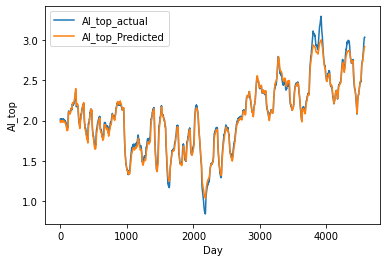

In [80]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='AI_top_actual')
plt.plot(predicted, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()


### multivariant prediction

In [14]:
df_multi=df

In [15]:
df_multi.head()

,AI_top,AI_middle,AI_bottom,Furnace
Time,,,,
2009-10-01 08:14:00,2.00000,3.00000,4.00000,8.50000
2009-10-01 08:15:00,2.00360,3.00954,3.99831,8.50735
2009-10-01 08:16:00,2.00870,2.99518,3.97746,8.50977
2009-10-01 08:17:00,2.00385,3.01356,3.97262,8.50838
2009-10-01 08:18:00,1.99852,3.02963,3.98841,8.50365


In [27]:
df_multi=df_multi.drop(['AI_middle'],axis=1)

In [28]:
def df_to_X_y(df, window_size=6):
  df_np = df_multi.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = [df_np[i+window_size][0], df_np[i+window_size][1]]
    y.append(label)
  return np.array(X), np.array(y)

In [29]:
X1,y1= df_to_X_y(df_multi,window_size=6)
X1.shape, y1.shape

((5723, 6, 3), (5723, 2))

In [30]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [31]:
split_index = int(len(X1) * 0.8)

split_index

4578

In [36]:
X_train = X1[:split_index]
X_test = X1[split_index:]

y_train = y1[:split_index]
y_test = y1[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4578, 6, 3), (1145, 6, 3), (4578, 2), (1145, 2))

In [33]:
window_size=6
#X_train = X_train.reshape((-1, window_size,window_size,1))
#X_test = X_test.reshape((-1, 2*window_size,1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4578, 6, 3), (1145, 6, 3), (9156, 1), (2290, 1))

In [37]:
X_train [0]


array([[2.     , 4.     , 8.5    ],
       [2.0036 , 3.99831, 8.50735],
       [2.0087 , 3.97746, 8.50977],
       [2.00385, 3.97262, 8.50838],
       [1.99852, 3.98841, 8.50365],
       [1.9971 , 3.99264, 8.50548]])

In [38]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4578, 6, 3]),
 torch.Size([1145, 6, 3]),
 torch.Size([4578, 2]),
 torch.Size([1145, 2]))

In [40]:
y_train [0]


tensor([2.0026, 3.9940])

In [41]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [84]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [85]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 6, 3]) torch.Size([128, 2])


In [86]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(3, 6, 3)
model.to(device)
model

LSTM(
  (lstm): LSTM(3, 6, num_layers=3, batch_first=True)
  (fc): Linear(in_features=6, out_features=2, bias=True)
)

In [87]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [88]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [89]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Val Loss: 10.010
***************************************************

Epoch: 2
Val Loss: 7.835
***************************************************

Epoch: 3
Val Loss: 5.556
***************************************************

Epoch: 4
Val Loss: 3.958
***************************************************

Epoch: 5
Val Loss: 2.835
***************************************************

Epoch: 6
Val Loss: 1.957
***************************************************

Epoch: 7
Val Loss: 1.332
***************************************************

Epoch: 8
Val Loss: 0.931
***************************************************

Epoch: 9
Val Loss: 0.670
***************************************************

Epoch: 10
Val Loss: 0.496
***************************************************



In [64]:
y_train[:,0]

tensor([2.0026, 2.0144, 2.0167,  ..., 3.0351, 3.0392, 3.0372])

In [90]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()


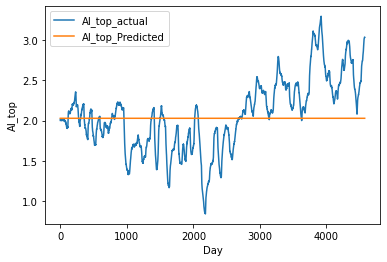

In [91]:

plt.plot(y_train[:,0], label='AI_top_actual')
plt.plot(predicted[:,0], label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()



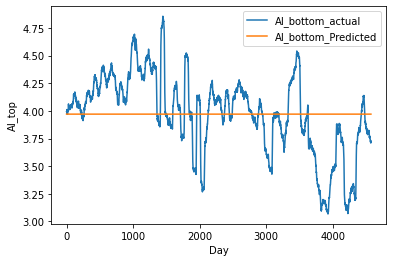

In [83]:
plt.plot(y_train[:,1], label='AI_bottom_actual')
plt.plot(predicted[:,1], label='AI_bottom_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

## Univariant with more varaibles

In [93]:
df=pd.read_csv('Fractionator.csv')

In [94]:
list(df.columns)

['Time',
 "AI_2020_OVERHEAD_C5'S_MOL",
 "AI_2021_MIDDLE_C7'S_MOL",
 "AI_2022_BOTTOM_C3'S_MOL",
 'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
 'FIC-2101_PV_TOP_PRODUCT_MBBL/D',
 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
 'FI-2005_PV_FEED_FLOW_MBBL/D',
 'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
 'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
 'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
 'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
 'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
 'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
 'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
 'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%',
 'FIC_2004_PV_TOP_REFLUX_MBBL/D',
 'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',
 'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF']

In [96]:
df=df.drop(["AI_2021_MIDDLE_C7'S_MOL", "AI_2022_BOTTOM_C3'S_MOL"],axis=1)

In [97]:
list(df.columns)

['Time',
 "AI_2020_OVERHEAD_C5'S_MOL",
 'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
 'FIC-2101_PV_TOP_PRODUCT_MBBL/D',
 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
 'FI-2005_PV_FEED_FLOW_MBBL/D',
 'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
 'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
 'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
 'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
 'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
 'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
 'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
 'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%',
 'FIC_2004_PV_TOP_REFLUX_MBBL/D',
 'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',
 'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF']

In [98]:
df=df.set_index(["Time'])
                 

SyntaxError: EOL while scanning string literal (<ipython-input-98-5a4500abec31>, line 1)

In [13]:
from sklearn.preprocessing import StandardScaler

# Fit scalers
scalers = {}
for x in df.columns:
  scalers[x] = StandardScaler().fit(df[x].values.reshape(-1, 1))

# Transform data via scalers
norm_df = df.copy()
for i, key in enumerate(scalers.keys()):
  norm = scalers[key].transform(norm_df.iloc[:, i].values.reshape(-1, 1))
  norm_df.iloc[:, i] = norm

In [16]:
norm_df['Time'] = df['Time']

In [17]:
norm_df.head()

,Time,AI_top,AI_middle,AI_bottom,FIC_2100_PV_FEED_FURNACE_FUEL_SCFH,FIC-2101_PV_TOP_PRODUCT_MBBL/D,FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D,FI-2005_PV_FEED_FLOW_MBBL/D,FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2001_OP_TOP_REFLUX_OUTPUT_%,FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D,FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D,FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%,FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D,FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D,FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%,FIC_2004_PV_TOP_REFLUX_MBBL/D,QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H,TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF
0,2009-10-01 08:14:00,-0.294419,-1.506604,0.095502,-1.011434,-1.050470,-0.154230,-1.573627,-0.566609,-0.176418,-0.208071,-0.22989,0.041396,-0.013827,-0.466246,-0.735174,-0.377748,-0.342087,-0.434907
1,2009-10-01 08:15:00,-0.286226,-1.465780,0.090809,-0.997710,-1.054382,-0.125321,-1.628040,-0.566609,-0.406018,-0.525040,-0.22989,-0.760193,-0.477483,-0.466246,-0.370745,-0.429676,-0.346818,-0.434907
2,2009-10-01 08:16:00,-0.274619,-1.527229,0.032901,-0.993192,-1.059440,-0.112454,-1.704846,-0.566609,-0.761213,-0.814388,-0.22989,-0.288797,-0.012488,-0.466246,-0.142661,-0.559994,-0.351382,-0.434907
3,2009-10-01 08:17:00,-0.285657,-1.448578,0.019459,-0.995787,-1.068073,-0.122848,-1.715407,-0.566609,-0.835099,-0.980187,-0.22989,-0.235280,-0.220194,-0.466246,-0.808576,-0.421169,-0.352814,-0.434907
4,2009-10-01 08:18:00,-0.297787,-1.379812,0.063313,-1.004619,-1.075037,-0.131504,-1.658390,-0.566609,-0.574645,-0.536710,-0.22989,-0.656430,-0.299318,-0.466246,-0.495467,-0.380361,-0.353188,-0.434907


In [20]:
df=norm_df

In [22]:
df=df[['Time','AI_top']]


In [23]:
# Defining a function that creates sequences and targets as shown above
def generate_sequences(df: pd.DataFrame, tw: int, pw: int, target_columns, drop_targets=False):
  '''
  df: Pandas DataFrame of the univariate time-series
  tw: Training Window - Integer defining how many steps to look back
  pw: Prediction Window - Integer defining how many steps forward to predict

  returns: dictionary of sequences and targets for all sequences
  '''
  data = dict() # Store results into a dictionary
  L = len(df)
  for i in range(L-tw):
    # Option to drop target from dataframe
    if drop_targets:
      df.drop(target_columns, axis=1, inplace=True)

    # Get current sequence  
    sequence = df[i:i+tw].values
    # Get values right after the current sequence
    target = df[i+tw:i+tw+pw][target_columns].values
    data[i] = {'sequence': sequence, 'target': target}
  return data

In [41]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
  #  df.set_index('Time', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'AI_top(t-{i})'] = df['AI_top'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Time,AI_top,AI_top(t-1),AI_top(t-2),AI_top(t-3),AI_top(t-4),AI_top(t-5),AI_top(t-6),AI_top(t-7)
7,2009-10-01 08:21:00,-0.261647,-0.288502,-0.301019,-0.297787,-0.285657,-0.274619,-0.286226,-0.294419
8,2009-10-01 08:22:00,-0.256435,-0.261647,-0.288502,-0.301019,-0.297787,-0.285657,-0.274619,-0.286226
9,2009-10-01 08:23:00,-0.240527,-0.256435,-0.261647,-0.288502,-0.301019,-0.297787,-0.285657,-0.274619
10,2009-10-01 08:24:00,-0.257823,-0.240527,-0.256435,-0.261647,-0.288502,-0.301019,-0.297787,-0.285657
11,2009-10-01 08:25:00,-0.243508,-0.257823,-0.240527,-0.256435,-0.261647,-0.288502,-0.301019,-0.297787
...,...,...,...,...,...,...,...,...,...
5815,2009-10-05 09:09:00,-1.058056,-1.038051,-1.037755,-1.017136,-1.017182,-1.002343,-1.011356,-0.988415
5816,2009-10-05 09:10:00,-1.063040,-1.058056,-1.038051,-1.037755,-1.017136,-1.017182,-1.002343,-1.011356
5817,2009-10-05 09:11:00,-1.071734,-1.063040,-1.058056,-1.038051,-1.037755,-1.017136,-1.017182,-1.002343
5818,2009-10-05 09:12:00,-1.045402,-1.071734,-1.063040,-1.058056,-1.038051,-1.037755,-1.017136,-1.017182


In [42]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np.shape


(5722, 9)

In [43]:
X=dc(np.flip(X,axis=1))
X.shape

NameError: name 'X' is not defined

In [45]:
split_index = int(len(X) * 0.95)

split_index

NameError: name 'X' is not defined

In [44]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

NameError: name 'X' is not defined

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [24]:
class SequenceDataset(Dataset):

  def __init__(self, df):
    self.data = df

  def __getitem__(self, idx):
    sample = self.data[idx]
    return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
  
  def __len__(self):
    return len(self.data)

In [32]:
import torch.utils.data  as data



In [33]:
# Here we are defining properties for our model

BATCH_SIZE = 16 # Training batch size
split = 0.8 # Train/Test Split ratio
sequence_len=10
nout=1
sequences = generate_sequences(df, sequence_len, nout, 'AI_top')
dataset = SequenceDataset(sequences)

# Split the data according to our split ratio and load each subset into a
# separate DataLoader object
train_len = int(len(dataset)*split)
lens = [train_len, len(dataset)-train_len]
train_ds, test_ds = data.random_split(dataset, lens)
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [39]:
train_ds

In [34]:
class LSTMForecaster(nn.Module):


  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
    '''
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
    super().__init__()

    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # set option for device selection

    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # As we have transformed our data in this way
    
    # first dense after lstm
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden) 
    # Dropout layer 
    self.dropout = nn.Dropout(p=dropout)

    # Create fully connected layers (n_hidden x n_deep_layers)
    dnn_layers = []
    for i in range(n_deep_layers):
      # Last layer (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, n_outputs))
      # All other layers (n_hidden x n_hidden) with dropout option
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, nhid))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # compile DNN layers
    self.dnn = nn.Sequential(*dnn_layers)

  def forward(self, x):

    # Initialize hidden state
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)

    # move hidden state to device
    if self.use_cuda:
      hidden_state = hidden_state.to(device)
      cell_state = cell_state.to(device)
        
    self.hidden = (hidden_state, cell_state)

    # Forward Pass
    x, h = self.lstm(x, self.hidden) # LSTM
    x = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
    x = self.fc1(x) # First Dense
    return self.dnn(x) # Pass forward through fully connected DNN.

In [35]:
nhid = 50 # Number of nodes in the hidden layer
n_dnn_layers = 5 # Number of hidden fully connected layers
nout = 1 # Prediction Window
sequence_len = 180 # Training Window

# Number of features (since this is a univariate timeseries we'll set
# this to 1 -- multivariate analysis is coming in the future)
ninp = 1

# Device selection (CPU | GPU)
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'

# Initialize the model
model = LSTMForecaster(ninp, nhid, nout, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)

In [36]:
# Set learning rate and number of epochs to train over
lr = 4e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [37]:
# Lists to store training and validation losses
t_losses, v_losses = [], []
# Loop over epochs
for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0

  # train step
  model.train()
  # Loop over train dataset
  for x, y in trainloader:
    optimizer.zero_grad()
    # move inputs to device
    x = x.to(device)
    y  = y.squeeze().to(device)
    # Forward Pass
    preds = model(x).squeeze()
    loss = criterion(preds, y) # compute batch loss
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
  epoch_loss = train_loss / len(trainloader)
  t_losses.append(epoch_loss)
  
  # validation step
  model.eval()
  # Loop over validation dataset
  for x, y in testloader:
    with torch.no_grad():
      x, y = x.to(device), y.squeeze().to(device)
      preds = model(x).squeeze()
      error = criterion(preds, y)
    valid_loss += error.item()
  valid_loss = valid_loss / len(testloader)
  v_losses.append(valid_loss)
      
  print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')
plot_losses(t_losses, v_losses)

[2023-04-10 00:05:49.477 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:64 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-10 00:05:49.786 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:64 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
def make_predictions_from_dataloader(model, unshuffled_dataloader):
  model.eval()
  predictions, actuals = [], []
  for x, y in unshuffled_dataloader:
    with torch.no_grad():
      p = model(x)
      predictions.append(p)
      actuals.append(y.squeeze())
  predictions = torch.cat(predictions).numpy()
  actuals = torch.cat(actuals).numpy()
  return predictions.squeeze(), actuals

In [ ]:
  def one_step_forecast(model, history):
      '''
      model: PyTorch model object
      history: a sequence of values representing the latest values of the time 
      series, requirement -> len(history.shape) == 2
    
      outputs a single value which is the prediction of the next value in the
      sequence.
      '''
      model.cpu()
      model.eval()
      with torch.no_grad():
        pre = torch.Tensor(history).unsqueeze(0)
        pred = self.model(pre)
      return pred.detach().numpy().reshape(-1)

  def n_step_forecast(data: pd.DataFrame, target: str, tw: int, n: int, forecast_from: int=None, plot=False):
      '''
      n: integer defining how many steps to forecast
      forecast_from: integer defining which index to forecast from. None if
      you want to forecast from the end.
      plot: True if you want to output a plot of the forecast, False if not.
      '''
      history = data[target].copy().to_frame()
      
      # Create initial sequence input based on where in the series to forecast 
      # from.
      if forecast_from:
        pre = list(history[forecast_from - tw : forecast_from][target].values)
      else:
        pre = list(history[self.target])[-tw:]

      # Call one_step_forecast n times and append prediction to history
      for i, step in enumerate(range(n)):
        pre_ = np.array(pre[-tw:]).reshape(-1, 1)
        forecast = self.one_step_forecast(pre_).squeeze()
        pre.append(forecast)
      
      # The rest of this is just to add the forecast to the correct time of 
      # the history series
      res = history.copy()
      ls = [np.nan for i in range(len(history))]

      # Note: I have not handled the edge case where the start index + n is 
      # before the end of the dataset and crosses past it.
      if forecast_from:
        ls[forecast_from : forecast_from + n] = list(np.array(pre[-n:]))
        res['forecast'] = ls
        res.columns = ['actual', 'forecast']
      else:
        fc = ls + list(np.array(pre[-n:]))
        ls = ls + [np.nan for i in range(len(pre[-n:]))]
        ls[:len(history)] = history[self.target].values
        res = pd.DataFrame([ls, fc], index=['actual', 'forecast']).T
      return res